eda1 link: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/eda1_w_data_direct_from_wrangling.ipynb

In [129]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

import itertools
from library.sb_utils import save_file

In [2]:
df = pd.read_csv('../data/processed/full_data_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_by_user_sequence  int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_sequence    int64  
 8   reordered               int64  
 9   product_name            object 
 10  aisle_name              object 
 11  dept_name               object 
 12  aisle_id                int64  
 13  department_id           int64  
 14  eval_set                object 
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


In [3]:
# Find just one user to explore with.
prolific_users = df[df['order_by_user_sequence']>100]
len(prolific_users['user_id'].unique())

0

In [4]:
prolific_users = df[df['order_by_user_sequence']==100]
len(prolific_users['user_id'].unique())

867

In [5]:
prolific_users['add_to_cart_sequence'].max()

47

In [6]:
prolific_user_w_biggest_cart = prolific_users[prolific_users['add_to_cart_sequence']==47]
prolific_user_w_biggest_cart

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5263305,1629423,32099,100,1,14,1.0,27966,47,1,Organic Raspberries,packaged vegetables fruits,produce,123,4,train


In [7]:
practice_user = df[df['user_id']==32099]
practice_user.sample(7)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5262162,615785,32099,36,2,11,1.0,11576,10,1,Corn Chips,chips pretzels,snacks,107,19,prior
5261662,2154990,32099,13,2,15,1.0,34358,12,1,Garlic,fresh vegetables,produce,83,4,prior
5262773,699779,32099,67,5,10,2.0,49105,8,1,Classic with Tuna Anchovies & Whitefish Cat Food,cat food care,pets,41,8,prior
5261613,20145,32099,11,1,20,1.0,27966,19,1,Organic Raspberries,packaged vegetables fruits,produce,123,4,prior
5263348,1629423,32099,100,1,14,1.0,39636,22,1,With Bleach Cleanser,cleaning products,household,114,17,train
5262093,659525,32099,33,1,15,4.0,36537,31,1,Almond Walnut Macadamia Plus Bar,energy granola bars,snacks,3,19,prior
5261746,1757499,32099,17,4,12,3.0,32734,30,0,Spaghetti,dry pasta,dry goods pasta,131,9,prior


In [8]:
# Save version of this df before adding new rows
pu_unchanged = practice_user
pu_unchanged.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261360,2959648,32099,1,0,17,NaN,40285,18,0,Traditional Snack Mix,trail mix snack mix,snacks,125,19,prior
5261361,2959648,32099,1,0,17,NaN,27966,15,0,Organic Raspberries,packaged vegetables fruits,produce,123,4,prior


In [9]:
# Tease out whether each item is reordered or not each order.
order1 = practice_user[practice_user['order_by_user_sequence']==1
                           ]['product_id'].unique().tolist()
len(order1)

26

In [10]:
order2 = practice_user[practice_user['order_by_user_sequence']==2
                           ]['product_id'].unique().tolist()
len(order2)

12

In [11]:
only1 = [x for x in order1 if x not in order2]
len (only1)

25

In [12]:
# Add rows so that non-reordered items are present in order 2
practice_user[practice_user['order_by_user_sequence']==1].sample(1)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261364,2959648,32099,1,0,17,NaN,26209,9,0,Limes,fresh fruits,produce,24,4,prior


In [13]:
practice_user[practice_user['order_by_user_sequence']==2].sample(1)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261388,309518,32099,2,1,15,1.0,44987,5,0,Heavy Whipping Cream,cream,dairy eggs,53,16,prior


In [14]:
order2deets = {'order_id':309518, 'user_id':32099, 
               'order_by_user_sequence':2, 'order_dow':1, 
               'order_hour_of_day':15, 'days_since_prior_order': 1.0,
               'product_id': only1, 'reordered':0}

order2_new_rows = pd.DataFrame.from_dict(order2deets)

order2_new_rows.head()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,309518,32099,2,1,15,1.0,40285,0
1,309518,32099,2,1,15,1.0,27966,0
2,309518,32099,2,1,15,1.0,34969,0
3,309518,32099,2,1,15,1.0,7419,0
4,309518,32099,2,1,15,1.0,26209,0


In [15]:
practice_user = pd.concat([practice_user, order2_new_rows])
practice_user.sample(10)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261585,2819872,32099,10,0,14,3.0,35221,4.0,1,Lime Sparkling Water,water seltzer sparkling water,beverages,115.0,7.0,prior
5261470,931900,32099,4,1,20,4.0,24618,20.0,0,Vitamin C Raspberry/Tangerine/Super Orange Fla...,vitamins supplements,personal care,47.0,11.0,prior
5262698,2431985,32099,64,0,14,3.0,4085,13.0,1,Chocolate Peanut Butter Nutrition Bar,energy granola bars,snacks,3.0,19.0,prior
5263055,970868,32099,84,5,14,9.0,42372,26.0,1,Pineapple on the Bottom Greek Yogurt,yogurt,dairy eggs,120.0,16.0,prior
5263292,2564156,32099,99,0,0,10.0,23909,7.0,1,2% Reduced Fat Milk,milk,dairy eggs,84.0,16.0,prior
5262477,2301592,32099,52,4,10,6.0,21927,23.0,1,Organic Boneless Skinless Chicken Breast,poultry counter,meat seafood,35.0,12.0,prior
5262343,1542626,32099,44,2,14,3.0,13176,1.0,1,Bag of Organic Bananas,fresh fruits,produce,24.0,4.0,prior
5262188,2807181,32099,37,3,8,15.0,23296,19.0,1,Blueberry on the Bottom Nonfat Greek Yogurt,yogurt,dairy eggs,120.0,16.0,prior
5262453,2809278,32099,51,5,13,1.0,44156,16.0,1,Strawberry on the Bottom Nonfat Greek Yogurt,yogurt,dairy eggs,120.0,16.0,prior
5263109,3160253,32099,88,2,9,1.0,29910,10.0,1,Super Moist Yellow Cake Mix,doughs gelatins bake mixes,pantry,105.0,13.0,prior


Now find a way to iterate and do this for every order. Find items from order n not reordered in order n+1. Find deets for order n+1. Add rows to practice_user with n+1 deets and n-only products

In [16]:
# This person has 100 orders, so I'm working from n
# (order_by_user_sequence) 2-99 and n+1 would be orders 3-100

# Start with creating orders' deets in dictionary form

orders_deets = practice_user.iloc[:,0:6].reset_index(drop=True)
orders_deets = orders_deets.groupby('order_by_user_sequence').first()
orders_deets['sequence_column'] = orders_deets.index
orders_deets = orders_deets.reset_index(drop=True)
orders_deets.index = orders_deets.index + 1
orders_deets = orders_deets.rename(columns={'sequence_column':
                                            'order_by_user_sequence'})
orders_deets = orders_deets[['order_id', 'user_id', 
                             'order_by_user_sequence', 'order_dow', 
                             'order_hour_of_day', 'days_since_prior_order']]
orders_deets = orders_deets.to_dict(orient='index')
orders_deets

{1: {'order_id': 2959648,
  'user_id': 32099,
  'order_by_user_sequence': 1,
  'order_dow': 0,
  'order_hour_of_day': 17,
  'days_since_prior_order': nan},
 2: {'order_id': 309518,
  'user_id': 32099,
  'order_by_user_sequence': 2,
  'order_dow': 1,
  'order_hour_of_day': 15,
  'days_since_prior_order': 1.0},
 3: {'order_id': 2494101,
  'user_id': 32099,
  'order_by_user_sequence': 3,
  'order_dow': 4,
  'order_hour_of_day': 11,
  'days_since_prior_order': 3.0},
 4: {'order_id': 931900,
  'user_id': 32099,
  'order_by_user_sequence': 4,
  'order_dow': 1,
  'order_hour_of_day': 20,
  'days_since_prior_order': 4.0},
 5: {'order_id': 2154511,
  'user_id': 32099,
  'order_by_user_sequence': 5,
  'order_dow': 5,
  'order_hour_of_day': 16,
  'days_since_prior_order': 4.0},
 6: {'order_id': 825019,
  'user_id': 32099,
  'order_by_user_sequence': 6,
  'order_dow': 0,
  'order_hour_of_day': 8,
  'days_since_prior_order': 2.0},
 7: {'order_id': 455159,
  'user_id': 32099,
  'order_by_user_sequen

In [17]:
# Already finished with adding rows to order 2, can drop order 1.

orders_deets.pop(1)

{'order_id': 2959648,
 'user_id': 32099,
 'order_by_user_sequence': 1,
 'order_dow': 0,
 'order_hour_of_day': 17,
 'days_since_prior_order': nan}

In [18]:
orders_deets

{2: {'order_id': 309518,
  'user_id': 32099,
  'order_by_user_sequence': 2,
  'order_dow': 1,
  'order_hour_of_day': 15,
  'days_since_prior_order': 1.0},
 3: {'order_id': 2494101,
  'user_id': 32099,
  'order_by_user_sequence': 3,
  'order_dow': 4,
  'order_hour_of_day': 11,
  'days_since_prior_order': 3.0},
 4: {'order_id': 931900,
  'user_id': 32099,
  'order_by_user_sequence': 4,
  'order_dow': 1,
  'order_hour_of_day': 20,
  'days_since_prior_order': 4.0},
 5: {'order_id': 2154511,
  'user_id': 32099,
  'order_by_user_sequence': 5,
  'order_dow': 5,
  'order_hour_of_day': 16,
  'days_since_prior_order': 4.0},
 6: {'order_id': 825019,
  'user_id': 32099,
  'order_by_user_sequence': 6,
  'order_dow': 0,
  'order_hour_of_day': 8,
  'days_since_prior_order': 2.0},
 7: {'order_id': 455159,
  'user_id': 32099,
  'order_by_user_sequence': 7,
  'order_dow': 2,
  'order_hour_of_day': 8,
  'days_since_prior_order': 2.0},
 8: {'order_id': 1116627,
  'user_id': 32099,
  'order_by_user_sequenc

In [19]:
# Now iterate over practice_user df to find un-reordered items for
# each order and add them as new rows.

for n in range(2,100):
    # Get items from order n not reordered in order n+1
    order_n = practice_user[practice_user['order_by_user_sequence']==n
                           ]['product_id'].unique().tolist()
    order_n1 = practice_user[practice_user['order_by_user_sequence']==(
        n+1)]['product_id'].unique().tolist()
    only_n = [x for x in order_n if x not in order_n1]
    # Get n1 deets from the big deets dict
    order_n1_deets = orders_deets.get(n+1)
    # Add to n1 deets dict with product ids from order_n
    order_n1_deets.update({'product_id': only_n})
    # Turn dict into df of new rows
    order_n1_new_rows = pd.DataFrame.from_dict(order_n1_deets)
    # Add new rows to practice_user df
    practice_user = pd.concat([practice_user, order_n1_new_rows])

practice_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34021 entries, 5261360 to 471
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34021 non-null  int64  
 1   user_id                 34021 non-null  int64  
 2   order_by_user_sequence  34021 non-null  int64  
 3   order_dow               34021 non-null  int64  
 4   order_hour_of_day       34021 non-null  int64  
 5   days_since_prior_order  33995 non-null  float64
 6   product_id              34021 non-null  int64  
 7   add_to_cart_sequence    1992 non-null   float64
 8   reordered               2017 non-null   float64
 9   product_name            1992 non-null   object 
 10  aisle_name              1992 non-null   object 
 11  dept_name               1992 non-null   object 
 12  aisle_id                1992 non-null   float64
 13  department_id           1992 non-null   float64
 14  eval_set                1992 non-n

In [20]:
practice_user[practice_user['order_by_user_sequence']==3]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set
5261398,2494101,32099,3,4,11,3.0,27966,14.0,1.0,Organic Raspberries,packaged vegetables fruits,produce,123.0,4.0,prior
5261399,2494101,32099,3,4,11,3.0,23909,20.0,0.0,2% Reduced Fat Milk,milk,dairy eggs,84.0,16.0,prior
5261400,2494101,32099,3,4,11,3.0,45698,38.0,0.0,One Ply Choose A Size Big Roll Paper Towel Rolls,paper goods,household,54.0,17.0,prior
5261401,2494101,32099,3,4,11,3.0,31717,27.0,0.0,Organic Cilantro,fresh herbs,produce,16.0,4.0,prior
5261402,2494101,32099,3,4,11,3.0,33198,45.0,0.0,Sparkling Natural Mineral Water,water seltzer sparkling water,beverages,115.0,7.0,prior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2494101,32099,3,4,11,3.0,18435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2494101,32099,3,4,11,3.0,29603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2494101,32099,3,4,11,3.0,47403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2494101,32099,3,4,11,3.0,34208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Deal with all the NaNs I just made. 
# add_to_cart_sequence can stay: NaN is accurate in this context
# All new rows can have 'reordered' value of 0

practice_user['reordered'] = practice_user['reordered'].fillna(0)
practice_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34021 entries, 5261360 to 471
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34021 non-null  int64  
 1   user_id                 34021 non-null  int64  
 2   order_by_user_sequence  34021 non-null  int64  
 3   order_dow               34021 non-null  int64  
 4   order_hour_of_day       34021 non-null  int64  
 5   days_since_prior_order  33995 non-null  float64
 6   product_id              34021 non-null  int64  
 7   add_to_cart_sequence    1992 non-null   float64
 8   reordered               34021 non-null  float64
 9   product_name            1992 non-null   object 
 10  aisle_name              1992 non-null   object 
 11  dept_name               1992 non-null   object 
 12  aisle_id                1992 non-null   float64
 13  department_id           1992 non-null   float64
 14  eval_set                1992 non-n

In [22]:
# Remaining rows can be filled based on the product_id column value
# Need to get dictionaries for department_id:dept_name, 
# aisle_id:aisle_name, product_id:product_name, aisle_id:department_id, 
# product_id:aisle_id

prod_id_name_dict = df.set_index('product_id').to_dict()['product_name']
prod_id_name_dict

{196: 'Soda',
 14084: 'Organic Unsweetened Vanilla Almond Milk',
 26088: 'Aged White Cheddar Popcorn',
 12427: 'Original Beef Jerky',
 26405: 'XL Pick-A-Size Paper Towel Rolls',
 13176: 'Bag of Organic Bananas',
 13032: 'Cinnamon Toast Crunch',
 10258: 'Pistachios',
 30450: 'Creamy Almond Butter',
 25133: 'Organic String Cheese',
 41787: 'Bartlett Pears',
 17122: 'Honeycrisp Apples',
 10326: 'Organic Fuji Apples',
 49235: 'Organic Half & Half',
 46149: 'Zero Calorie Cola',
 35951: 'Organic Unsweetened Almond Milk',
 38928: '0% Greek Strained Yogurt',
 39657: 'Milk Chocolate Almonds',
 27845: 'Organic Whole Milk',
 27966: 'Organic Raspberries',
 47766: 'Organic Avocado',
 45066: 'Honeycrisp Apple',
 27344: 'Uncured Genoa Salami',
 20574: 'Roasted Turkey',
 30489: 'Original Hummus',
 22474: 'Cheddar Bunnies Snack Crackers',
 48110: 'Thin Stackers Brown Rice Lightly Salted',
 32792: 'Chipotle Beef & Pork Realstick',
 16589: 'Plantain Chips',
 12000: 'Baked Organic Sea Salt Crunchy Pea Sna

In [23]:
aisle_id_name_dict = df.set_index('aisle_id').to_dict()['aisle_name']
aisle_id_name_dict

{77: 'soft drinks',
 91: 'soy lactosefree',
 23: 'popcorn jerky',
 54: 'paper goods',
 24: 'fresh fruits',
 121: 'cereal',
 117: 'nuts seeds dried fruit',
 88: 'spreads',
 21: 'packaged cheese',
 53: 'cream',
 120: 'yogurt',
 45: 'candy chocolate',
 84: 'milk',
 123: 'packaged vegetables fruits',
 96: 'lunch meat',
 67: 'fresh dips tapenades',
 78: 'crackers',
 107: 'chips pretzels',
 72: 'condiments',
 98: 'juice nectars',
 1: 'prepared soups salads',
 38: 'frozen meals',
 31: 'refrigerated',
 3: 'energy granola bars',
 48: 'breakfast bars pastries',
 20: 'oral hygiene',
 57: 'granola',
 42: 'frozen vegan vegetarian',
 49: 'packaged poultry',
 110: 'pickled goods olives',
 66: 'asian foods',
 14: 'tofu meat alternatives',
 115: 'water seltzer sparkling water',
 93: 'breakfast bakery',
 94: 'tea',
 17: 'baking ingredients',
 112: 'bread',
 95: 'canned meat seafood',
 58: 'frozen breads doughs',
 37: 'ice cream ice',
 46: 'mint gum',
 69: 'soup broth bouillon',
 80: 'deodorants',
 108: 

In [24]:
dept_id_name_dict = df.set_index('department_id').to_dict()['dept_name']
dept_id_name_dict

{7: 'beverages',
 16: 'dairy eggs',
 19: 'snacks',
 17: 'household',
 4: 'produce',
 14: 'breakfast',
 13: 'pantry',
 20: 'deli',
 1: 'frozen',
 11: 'personal care',
 12: 'meat seafood',
 6: 'international',
 3: 'bakery',
 15: 'canned goods',
 9: 'dry goods pasta',
 5: 'alcohol',
 8: 'pets',
 18: 'babies',
 2: 'other',
 21: 'missing',
 10: 'bulk'}

In [25]:
prod_aisle_dict = df.set_index('product_id').to_dict()['aisle_id']
prod_aisle_dict

{196: 77,
 14084: 91,
 26088: 23,
 12427: 23,
 26405: 54,
 13176: 24,
 13032: 121,
 10258: 117,
 30450: 88,
 25133: 21,
 41787: 24,
 17122: 24,
 10326: 24,
 49235: 53,
 46149: 77,
 35951: 91,
 38928: 120,
 39657: 45,
 27845: 84,
 27966: 123,
 47766: 24,
 45066: 24,
 27344: 96,
 20574: 96,
 30489: 67,
 22474: 78,
 48110: 78,
 32792: 23,
 16589: 107,
 12000: 72,
 35917: 98,
 8479: 78,
 16797: 24,
 19051: 107,
 8138: 67,
 47526: 21,
 7781: 21,
 28874: 1,
 47209: 24,
 24852: 24,
 37646: 24,
 36735: 96,
 45613: 38,
 34688: 31,
 32139: 67,
 21150: 38,
 22829: 78,
 9681: 38,
 33276: 67,
 49451: 67,
 22124: 120,
 47144: 91,
 1559: 120,
 17224: 3,
 38656: 3,
 19156: 120,
 21376: 107,
 48210: 48,
 47553: 20,
 14553: 57,
 5322: 3,
 5907: 48,
 33754: 120,
 17872: 120,
 18523: 120,
 24954: 120,
 4957: 120,
 46676: 120,
 40571: 120,
 32052: 78,
 46886: 120,
 40198: 120,
 17758: 120,
 5212: 123,
 22963: 96,
 2002: 42,
 23: 49,
 20084: 31,
 28918: 117,
 14306: 110,
 49273: 38,
 5450: 24,
 9124: 38,
 4

In [26]:
aisle_dept_dict = df.set_index('aisle_id').to_dict()['department_id']
aisle_dept_dict

{77: 7,
 91: 16,
 23: 19,
 54: 17,
 24: 4,
 121: 14,
 117: 19,
 88: 13,
 21: 16,
 53: 16,
 120: 16,
 45: 19,
 84: 16,
 123: 4,
 96: 20,
 67: 20,
 78: 19,
 107: 19,
 72: 13,
 98: 7,
 1: 20,
 38: 1,
 31: 7,
 3: 19,
 48: 14,
 20: 11,
 57: 14,
 42: 1,
 49: 12,
 110: 13,
 66: 6,
 14: 20,
 115: 7,
 93: 3,
 94: 7,
 17: 13,
 112: 3,
 95: 15,
 58: 1,
 37: 1,
 46: 19,
 69: 15,
 80: 11,
 108: 16,
 83: 4,
 13: 20,
 52: 1,
 4: 9,
 74: 17,
 28: 5,
 111: 17,
 128: 3,
 134: 5,
 16: 4,
 29: 13,
 19: 13,
 12: 9,
 81: 15,
 86: 16,
 101: 17,
 35: 12,
 50: 19,
 122: 12,
 99: 15,
 26: 7,
 87: 17,
 59: 15,
 36: 16,
 40: 8,
 32: 4,
 104: 13,
 63: 9,
 92: 18,
 85: 17,
 106: 12,
 130: 14,
 116: 1,
 51: 13,
 15: 12,
 89: 13,
 5: 13,
 129: 1,
 43: 3,
 6: 2,
 2: 16,
 100: 21,
 9: 9,
 41: 8,
 22: 11,
 131: 9,
 61: 19,
 25: 11,
 33: 6,
 109: 11,
 124: 5,
 30: 6,
 105: 13,
 90: 7,
 10: 17,
 34: 1,
 75: 17,
 71: 16,
 119: 1,
 125: 19,
 114: 17,
 39: 12,
 79: 1,
 62: 5,
 70: 11,
 47: 11,
 127: 11,
 8: 3,
 133: 11,
 64:

In [27]:
practice_user['product_name'] = practice_user['product_name'].fillna(
    practice_user['product_id'].map(prod_id_name_dict))

practice_user['aisle_id'] = practice_user['aisle_id'].fillna(
    practice_user['product_id'].map(prod_aisle_dict))

practice_user['department_id'] = practice_user['department_id'].fillna(
    practice_user['aisle_id'].map(aisle_dept_dict))

practice_user['aisle_name'] = practice_user['aisle_name'].fillna(
    practice_user['aisle_id'].map(aisle_id_name_dict))

practice_user['dept_name'] = practice_user['dept_name'].fillna(
    practice_user['department_id'].map(dept_id_name_dict))

practice_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34021 entries, 5261360 to 471
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34021 non-null  int64  
 1   user_id                 34021 non-null  int64  
 2   order_by_user_sequence  34021 non-null  int64  
 3   order_dow               34021 non-null  int64  
 4   order_hour_of_day       34021 non-null  int64  
 5   days_since_prior_order  33995 non-null  float64
 6   product_id              34021 non-null  int64  
 7   add_to_cart_sequence    1992 non-null   float64
 8   reordered               34021 non-null  float64
 9   product_name            34021 non-null  object 
 10  aisle_name              34021 non-null  object 
 11  dept_name               34021 non-null  object 
 12  aisle_id                34021 non-null  float64
 13  department_id           34021 non-null  float64
 14  eval_set                1992 non-n

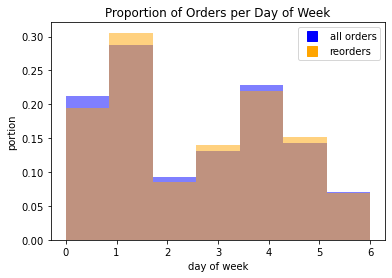

In [35]:
#Visualize reorder patterns for this user.
# Use the pu_unchanged dataset because I want to compare reorders with all
# ordered items, not with all items ever ordered compounding in each order.

user_reordered = pu_unchanged[pu_unchanged['reordered']==1]

plt.hist(pu_unchanged['order_dow'], color='blue', density=True, 
         alpha=0.5, bins=7)
plt.hist(user_reordered['order_dow'], color='orange', density=True, 
         alpha=0.5, bins=7)
plt.title('Proportion of Orders per Day of Week')
plt.xlabel('day of week')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', 
                       linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', 
                       linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

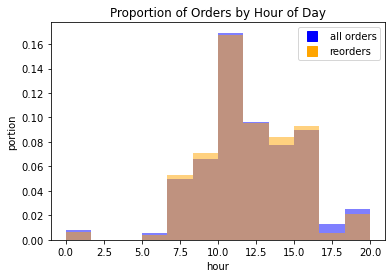

In [41]:
# In the overall df, dow changed little between reorders vs all orders
# This person seems similar. 

plt.hist(pu_unchanged['order_hour_of_day'], color='blue', 
         density=True, 
         alpha=0.5, bins=12)
plt.hist(user_reordered['order_hour_of_day'], color='orange', 
         density=True, 
         alpha=0.5, bins=12);
plt.title('Proportion of Orders by Hour of Day')
plt.xlabel('hour')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', 
                       linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', 
                       linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

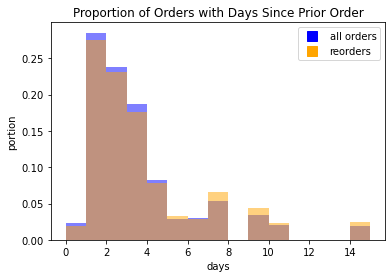

In [42]:
# In overall df, most people do most reordering from 7-10am
# This person has less of a clear pattern

plt.hist(pu_unchanged['days_since_prior_order'], color='blue', 
         density=True, 
         alpha=0.5, bins=15)
plt.hist(user_reordered['days_since_prior_order'], color='orange', 
         density=True, alpha=0.5, bins=15)
plt.title('Proportion of Orders with Days Since Prior Order')
plt.xlabel('days')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', 
                       linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', 
                       linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

This person only has 15 days between orders at most, which makes sense because they're a major customer. Overall, it seemed more reorders happened within 10 days. This person seems not to reorder in the first 4 days, which makes a sort of sense (no need to reorder if you just got it, no time to have run out). And they include reorders even if it has been more than 10 days since their last order.  

In [44]:
pu_unchanged['add_to_cart_sequence'].max()

47

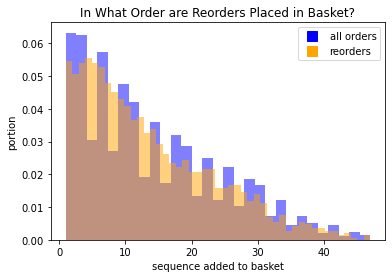

In [45]:
plt.hist(pu_unchanged['add_to_cart_sequence'], color='blue', density=True, 
         alpha=0.5, bins=29)
plt.hist(user_reordered['add_to_cart_sequence'], color='orange', 
         density=True, alpha=0.5, bins=47)
plt.title('In What Order are Reorders Placed in Basket?')
plt.xlabel('sequence added to basket')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', 
                       linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', 
                       linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

Most people put reorders in first. This person seems to have a regular pattern of placing some new items in the basket first, following by reorders, then more new, then more reorders, etc. 

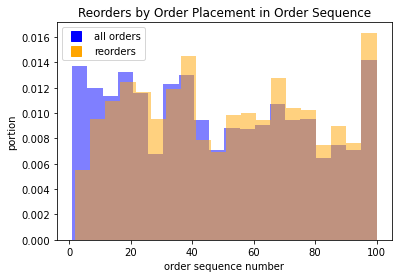

In [46]:
# Do explore more of the order sequence.
plt.hist(pu_unchanged['order_by_user_sequence'], color='blue', density=True, 
         alpha=0.5, bins=20)
plt.hist(user_reordered['order_by_user_sequence'], color='orange', 
         density=True, alpha=0.5, bins=20)
plt.title('Reorders by Order Placement in Order Sequence')
plt.xlabel('order sequence number')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', 
                       linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', 
                       linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

There is a similar trend here to the full df, with more reorders happening after more orders have been placed. But this person seems to have waited a bit longer before doing the bulk of their reordering. This person's behavior isn't grossly different from that of all users, though there are some differences. I'd like to do more exploration with this single user, and if I end up working with chunks of multiple users but not the entire df, I should make sure to try to find users whose behaviors reflect normal behavior, by choosing the users randomly.

In [108]:
# Use a DecisionTree to visualize one way how all this
# *could* be modeled.
# Get only the potentially useful, non-redundant columns. 

practice_user.columns

Index(['order_id', 'user_id', 'order_by_user_sequence', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_sequence', 'reordered', 'product_name', 'aisle_name',
       'dept_name', 'aisle_id', 'department_id', 'eval_set'],
      dtype='object')

In [176]:
pu_4models = practice_user.loc[:,['order_id', 'user_id', 'order_by_user_sequence', 
                            'order_dow', 'order_hour_of_day', 'days_since_prior_order', 
                            'product_id','add_to_cart_sequence', 'reordered', 'aisle_id',
                           'department_id']]
pu_4models.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,aisle_id,department_id
5261360,2959648,32099,1,0,17,NaN,40285,18.0,0.0,125.0,19.0
5261361,2959648,32099,1,0,17,NaN,27966,15.0,0.0,123.0,4.0


In [177]:
# Deal with remaining NaN values

pu_4models.isnull().any()

order_id                  False
user_id                   False
order_by_user_sequence    False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
product_id                False
add_to_cart_sequence       True
reordered                 False
aisle_id                  False
department_id             False
dtype: bool

In [178]:
pu_4models['days_since_prior_order'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 10., 15., nan])

In [179]:
pu_4models['days_since_prior_order'] = pu_4models['days_since_prior_order'].fillna(-1)
pu_4models['days_since_prior_order'].sort_values().unique()

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 10., 15.])

In [180]:
pu_4models['add_to_cart_sequence'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., nan])

In [181]:
pu_4models['add_to_cart_sequence'] = pu_4models['add_to_cart_sequence'].fillna(0)
pu_4models['add_to_cart_sequence'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47.])

In [182]:
pu_4models.isnull().any()

order_id                  False
user_id                   False
order_by_user_sequence    False
order_dow                 False
order_hour_of_day         False
days_since_prior_order    False
product_id                False
add_to_cart_sequence      False
reordered                 False
aisle_id                  False
department_id             False
dtype: bool

In [183]:
# Get ind/dep variables.

y = pu_4models['reordered']
X = pu_4models.drop('reordered', axis=1)

X.head(2)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,aisle_id,department_id
5261360,2959648,32099,1,0,17,-1.0,40285,18.0,125.0,19.0
5261361,2959648,32099,1,0,17,-1.0,27966,15.0,123.0,4.0


In [184]:
y = y.array.reshape(-1,1)

In [185]:
# Model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9885378398236591

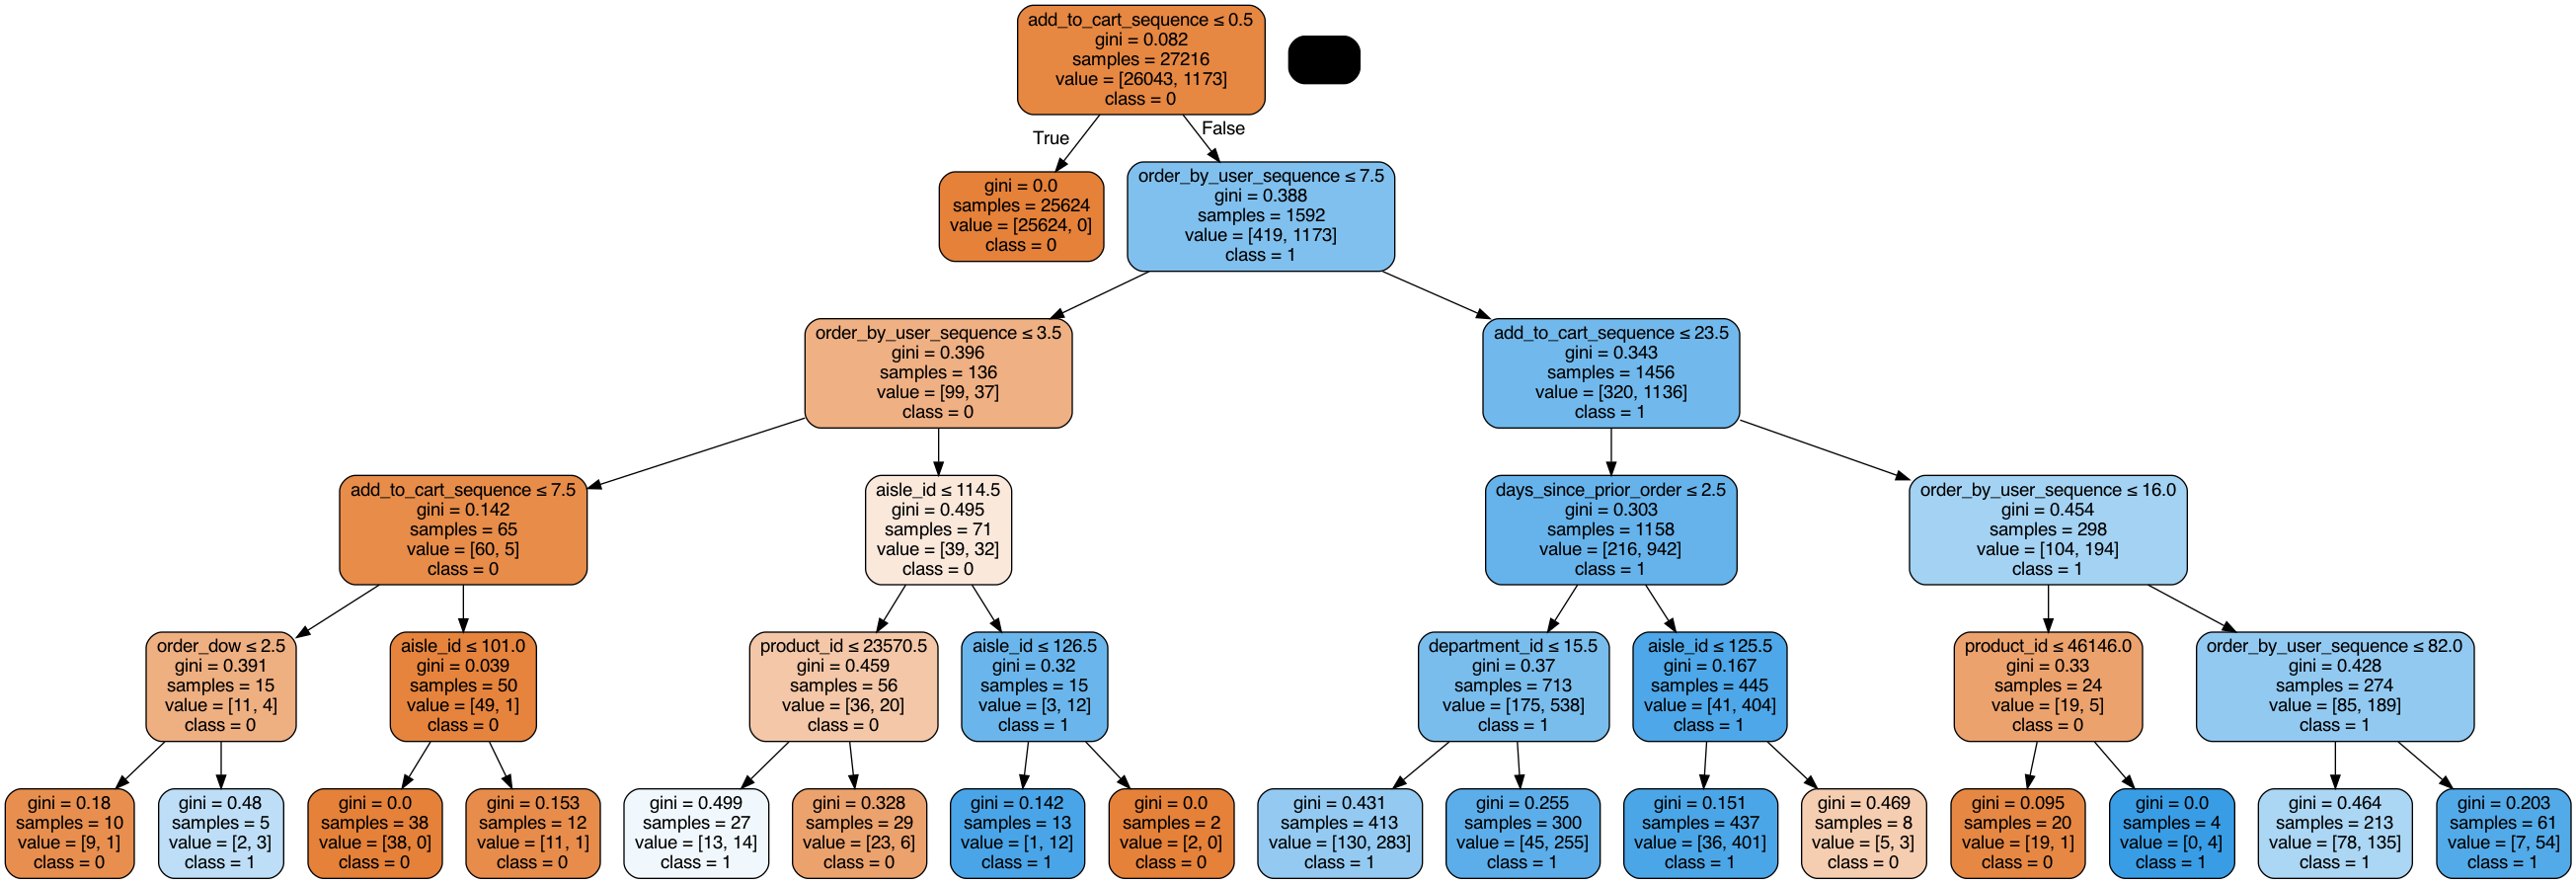

In [163]:
# Visualize

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, 
                special_characters=True, feature_names = X.columns, 
                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('pu_4models.png')
Image(graph.create_png())

It looks like the order_by_user_sequence and add_to_cart_sequence are the features being used most to make decisions. And, for example, most samples classified as non-reorders occur with order_by_user_sequence <3.5. Plenty here is consistent with what the histograms showed. There are tons of problems with this model, for example, categories being treated as ordinal just because their ids are integers. But it's been helpful in simply visualizing how a model could potentially shake out given existing data. 

Next:
- Cluster items in order to have fewer, hopefully more meaningful, products to work with. My prediction is that this will result in products becoming a more meaningful feature than it is shaping up to be so far. 
- Get a new notebook for this: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/eda3_product_clusters.ipynb 
- After that, features need to be engineered with dummies and such to be more appropriate for modeling, and I'll need to be working with more of the original, full df. 